# Dependencies

In [1]:
import MURA
import cv2
import image_manipulation
from multiprocessing import Pool
from models import *
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing
import json
from os import path, mkdir

import keras
from argparse import ArgumentParser
import tensorflow as tf
from sklearn import metrics

from skimage import exposure


2023-06-19 16:58:47.802709: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 16:58:47.861794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 16:58:49.058076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/clr/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model to Run
This section lets the user edit on what model parameters to run, the model directory and parameters should exist prior to changing the file path

In [2]:
# All editable variables
model_file_path = "models/model_6_UPAE"
# If preprocessing needs to run
run_preprocessing = False

In [3]:
# Get model parameters
try:
    params = json.load(open(model_file_path + '/parameters.json'))

    # Model to use
    model_is_VAE = params['is_VAE']
    # Model parameters
    multiplier = params['multiplier']
    latent_size = params['latent_size']
    input_shape = params['input_shape']

    # Training parameters
    epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    # Dataset Path
    image_paths = MURA.MURA_DATASET()
    dataset_file_path = params['dataset_path']
    all_image_paths = image_paths.get_combined_image_paths()
    all_image_paths = all_image_paths.to_numpy()[:,0]
except:
    raise Exception("No parameters.json file found in the model's directory.")

In [4]:
# each array contains the training, validation, and testing in order
image_datasets = {'train': [],
                'valid': [],
                'test': []}
for dataset_name in image_datasets.keys():
    for image_path in glob.glob(f'{dataset_file_path}/{dataset_name}/*.png'):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = exposure.rescale_intensity(image, in_range=(0, 255))
        image_datasets[dataset_name].append(image)
    image_datasets[dataset_name] = np.array(image_datasets[dataset_name])

# Model Training
This section creates and trains the model

In [5]:
if __name__ == "__main__":

    if model_is_VAE:
        model = VAE(False, input_shape, multiplier, latent_size)
    else:
        model = UPAE(True, input_shape, multiplier, latent_size)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.build(input_shape=(None,) + tuple(input_shape))

    model.compile(optimizer= optimizer, loss='mse'
                  ,metrics=[tf.keras.metrics.Accuracy()])
    
    # model.summary()
    
    try:
        model.load_weights(model_file_path + "/model_weights")
    except:
        np.random.shuffle(image_datasets['train'])

        validation_split = 0.05

        total_samples = len(image_datasets['train'])
        validation_samples = int(validation_split * total_samples)

        train_data = image_datasets['train'][:-validation_samples]
        validation_data = image_datasets['train'][-validation_samples:]

        # Where images of each epoch will be saved
        save_directory = model_file_path + '/callback_images'
        save_callback = SaveImageCallback(validation_data, save_directory=save_directory, vae=model_is_VAE)

        EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse_loss', patience=5,
                                                                  restore_best_weights=True)

        history_train = model.fit(train_data, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                validation_data=(validation_data, validation_data),
                                callbacks=[save_callback, EarlyStopping_callback])
        
        # Saving the model's history
        json.dump(history_train.history, open(model_file_path + '/history.json', 'w'))

        #Save weights
        model.save_weights(model_file_path + '/model_weights')
   
    

2023-06-19 16:58:59.098731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-19 16:58:59.098776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: epictetus.emperor-bebop.ts.net
2023-06-19 16:58:59.098788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: epictetus.emperor-bebop.ts.net
2023-06-19 16:58:59.098934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.116.4
2023-06-19 16:58:59.098963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.116.4
2023-06-19 16:58:59.098975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.116.4


Epoch 1/100
58/58 [==============================] - 41s 675ms/step - mse_loss: 6390.6372 - total_loss: 215.4093 - loss1: 160.7282 - loss2: 54.6811 - reconstruction_loss: -551.8429 - accuracy: 0.0237 - val_mse_loss: 4146.7246 - val_total_loss: 23.0869 - val_loss1: 7.4847 - val_loss2: 15.6022 - val_reconstruction_loss: -635.9216 - val_accuracy: 0.0028
Epoch 2/100
58/58 [==============================] - 39s 668ms/step - mse_loss: 4627.2485 - total_loss: 16.6460 - loss1: 2.6092 - loss2: 14.0369 - reconstruction_loss: -696.9087 - accuracy: 0.0018 - val_mse_loss: 4307.1685 - val_total_loss: 18.1142 - val_loss1: 5.7653 - val_loss2: 12.3489 - val_reconstruction_loss: -636.2905 - val_accuracy: 0.0015
Epoch 3/100
58/58 [==============================] - 39s 664ms/step - mse_loss: 4681.5591 - total_loss: 14.1030 - loss1: 2.0545 - loss2: 12.0485 - reconstruction_loss: -704.4610 - accuracy: 8.6914e-04 - val_mse_loss: 4294.7427 - val_total_loss: 15.8941 - val_loss1: 4.8165 - val_loss2: 11.0776 - v

# Plots Creation

In [6]:
# Create directory for saving images
save_directory = model_file_path + '/plots'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


In [7]:
# Get history of data
history = history_train.history

def create_plot(history, metric, title, save_name):
    plt.plot(history[metric], label=metric)
    plt.plot(history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.savefig(f'{save_directory}/{save_name}', dpi=300)
    plt.close()

# Check if UPAE or not
if model_is_VAE:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for reconstruction_loss
    create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
    # Create plot for kl_loss
    create_plot(history, 'kl_loss', 'KL Loss per Epoch', 'kl_loss.png')
else:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for total loss
    create_plot(history, 'total_loss', 'Total Loss per Epoch', 'total_loss.png')
    # Create plot for loss1
    create_plot(history, 'loss1', 'Loss 1 per Epoch', 'loss1.png')
    # Create plot for loss2
    create_plot(history, 'loss2', 'Loss 2 per Epoch', 'loss2.png')
    # Create plot for binary_crossentropy
#     create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
#     # Create plot for accuracy
#     create_plot(history, 'accuracy', 'Accuracy per Epoch', 'accuracy.png')
    

# Testing of the Model with the Test Set (CARA VERSION)
This section tests the model with the current test set
TODO: 
- Get the label of each image in the test set
- Test the images
- Create Linear Regression for the abnormality score to get the threshold for determining abnormal or normal images

In [13]:
test_images = []
labels = []
for image_path in glob.glob(f'{dataset_file_path}/test/*.png'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get if it contains positive or negative
    if 'positive' in image_path:
        test_images.append(image)
        labels.append(1)
    else:
        test_images.append(image)
        labels.append(0)
test_images = np.array(test_images)

In [14]:
history_valid = model.predict(image_datasets['test'], batch_size=batch_size)

In [15]:
abnor_scores = history_valid[1]
#converting to an array of numbers instead of tensor
abnor_scores = [item.numpy() for item in abnor_scores if isinstance(item, tf.Tensor)]
abnor_scores = [float(item) for item in abnor_scores]

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(labels, abnor_scores)
idx = None
for i in range(len(fpr)):
    fnr = 1 - tpr[i]
    if abs(fpr[i] - fnr) <= 5e-3:
        idx = i
        break
assert idx is not None

t = thresholds[idx]
y_pred = np.zeros_like(labels)
y_pred[abnor_scores < t] = 0
y_pred[abnor_scores >= t] = 1
pres = metrics.precision_score(labels, y_pred)
sens = metrics.recall_score(labels, y_pred, pos_label=1)
spec = metrics.recall_score(labels, y_pred, pos_label=0)
f1 = metrics.f1_score(labels, y_pred)
print('Error rate:{}'.format(fpr[idx]))
print('Precision:{} Sensitivity:{} Specificity:{} f1:{}\n'.format(
    pres, sens, spec, f1))

AssertionError: 

In [17]:
auc = metrics.roc_auc_score(labels, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(model_file_path+'/plots/roc_curve.png')



#ROC AUC Curve interpretation
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/


NameError: name 'y_pred' is not defined

## Getting variance image output from testing

In [ ]:
history_valid[3]

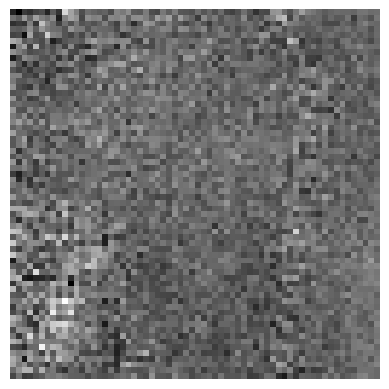

In [25]:
#variance from testing set
variance_tensor = history_valid[2][8]
variance_array = variance_tensor.numpy()
# Normalize the values between 0 and 1
normalized_array = (variance_array - np.min(variance_array)) / (np.max(variance_array) - np.min(variance_array))
# Scale the values to the range of pixel values (0-255)
scaled_array = (normalized_array * 255).astype(np.uint8)

plt.imshow(scaled_array, cmap='gray')
plt.axis('off')
plt.show()

In [19]:
#history_valid[2] is the variance from the test set
image = history_valid[2][8]
image = image.numpy().astype(np.uint8)

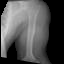

In [28]:
image = history_valid[3][8]

from PIL import Image
image = Image.fromarray(image)
image


# Saving of final reconstructed images 

In [29]:
# Create directory in models folder for reconstructed images
dataset_name = dataset_file_path.split('/')[-1]
reconstructed_images_path = model_file_path + "/" + dataset_name
if not path.exists(reconstructed_images_path):
    mkdir(reconstructed_images_path)

In [30]:
for x in range(len(history_valid)):
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].imshow(image_datasets['test'][x])
    axs[0].set_title('Original Image')
    new_image = np.floor(history_valid[0][x]).astype(np.uint8)
    axs[1].imshow(new_image)
    axs[1].set_title('Reconstructed Image')
    plt.savefig(f'{reconstructed_images_path}/Valid_Image_{x}.png')
    plt.close()
    break

# Saving of Model Weights

In [31]:
model.save_weights(model_file_path + '/model_weights.h5')

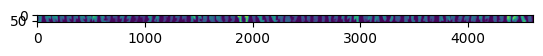

In [33]:
new_image = np.concatenate(history_valid[0], axis=1)
plt.imshow(new_image)